# Variational Classification

Below are notes from each section of the qiskit course documentation found on this page: https://learn.qiskit.org/course/machine-learning/variational-classification

## Variational algorithms

Variational algorithms were first introduced in 2014 and are a near-term algorithm that can be executedon current quantum computers. They work by using a parameterized quantum circuit (ansatz) to prepare a quantum state that you then measure the expectation value. A cost function is defined for how good the problem is solved by that quantum state and a classical computer calculates that cost function and provides updated circuit parameters using an optimization algorithm. The goal is to find the optimal set of parameters that minimizes the cost function.

![image va](./va.svg)

## The variational quantum classifier

The variational quantum classifier is a variational algorithm where the measured expecation value is interpreted as the actual output of the classifier. The following quantum circuit/state is built:

$\ket{\psi(\vec{x_i}; \vec{\theta})} = U_{W(\vec{\theta})}U_{\phi(\vec{x_i})}\ket{0}$

where $U_{W(\vec{\theta})}$ is the parameterized circuit / variational form and $U_{\phi(\vec{x_i})}$ is the data encoding circuit. After creating, running, and measuring the circuit of n qubits, we're left with an n length bitstring. This n-length bitstring is interpretted as the classifier output but this "interpretation" must be a function of some kind that maps the bitstring to a binary classification. A popular choice is the parity function which is 0 for an even number of 1's and 1 for an odd number of 1's.

In the training phase, the parameter values of $\vec{\theta}$ are optimized for the best predictions. The classical computer compares the predicted labels $\hat{y_i}$ to the true labels and calculates the success of the predictions using a cost function. The classical computer also optimizes the parameter values and iteratively chooses the next values for which the circuit is re-run.

### Full implementation

We can implement all the separate components of a variational quantum classifier here. First, we'll create 40 training data points and 10 testing points where half of the values belong to one class and half belong to the other class. Our datapoints have 2 features.

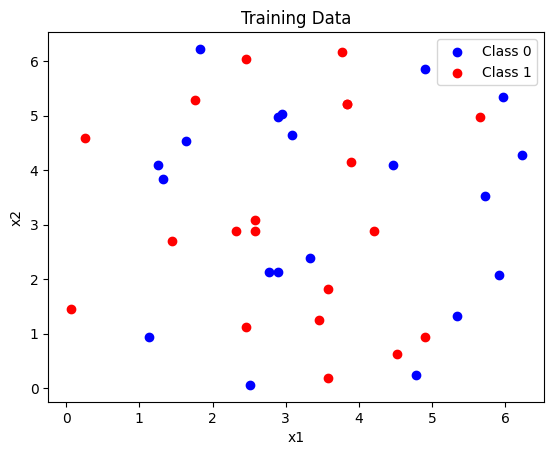

In [19]:
from qiskit.utils import algorithm_globals
algorithm_globals.random_seed = 3142

import numpy as np
np.random.seed(algorithm_globals.random_seed)

from qiskit_machine_learning.datasets import ad_hoc_data

## Generate the dataset
TRAIN_DATA, TRAIN_LABELS, TEST_DATA, TEST_LABELS = (
    ad_hoc_data(training_size=20,
                test_size=5,
                n=2,
                gap=0.3,
                one_hot=False)
)


## Visualize the training data
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
class_0_idxs = np.where(TRAIN_LABELS == 0)[0]
class_1_idxs = np.where(TRAIN_LABELS == 1)[0]

for idxs, color in zip([class_0_idxs, class_1_idxs], ['blue', 'red']):
    plt.scatter(
        TRAIN_DATA[idxs, 0],
        TRAIN_DATA[idxs, 1],
        c=color,
        label = "Class 0" if color == "blue" else "Class 1"
    )

ax.set_title("Training Data")
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.legend()

Next, we can prepare our circuit. This will consist of a) the Qiskit ZZFeatureMap to encode our data from classical datapoints to unique quantum states, and b) the Qiskit TwoLocal circuit as the variational form. The variational form circuit will have Y and Z rotations and controlled phase-gates for entangling.

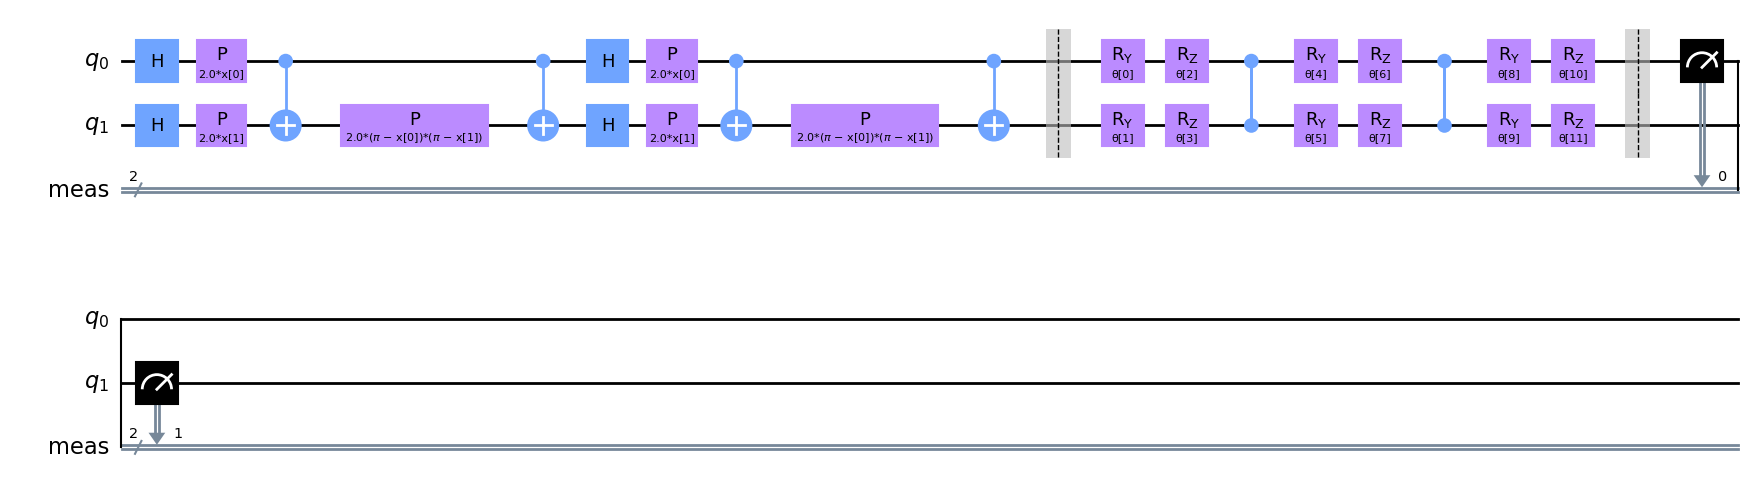

In [21]:
from qiskit.circuit.library import ZZFeatureMap, TwoLocal
FEATURE_MAP = ZZFeatureMap(feature_dimension=2, reps=2)
FEATURE_MAP.barrier() # add barrier for visual separation of data encoding vs quantum model
VAR_FORM = TwoLocal(2, ['ry', 'rz'], 'cz', reps=2)

AD_HOC_CIRCUIT = FEATURE_MAP.compose(VAR_FORM)
AD_HOC_CIRCUIT.measure_all()
AD_HOC_CIRCUIT.decompose().draw()

The above circuit has placeholders for the actual rotation and controlled-phase gate values. The function below will take as inputs the datapoint values ($x_i$) and the parameter values ($\vec{\theta}$) and binds them to the circuit.

In [22]:
def circuit_instance(data, variational):
    """Assigns parameter values to `AD_HOC_CIRCUIT`.
    Args:
        data (list): Data values for the feature map
        variational (list): Parameter values for `VAR_FORM`
    Returns:
        QuantumCircuit: `AD_HOC_CIRCUIT` with parameters assigned
    """
    parameters = {}
    for i, p in enumerate(FEATURE_MAP.ordered_parameters):
        parameters[p] = data[i]
    for i, p in enumerate(VAR_FORM.ordered_parameters):
        parameters[p] = variational[i]
    return AD_HOC_CIRCUIT.assign_parameters(parameters)

We then need to create a little helper function that turns the quantum circuit measurement (some bitstring) into a binary classificatiion using the parity function. Because our circuit will be run multiple times, we'll get many different outputs/labels for our input and so we need to turn that into a probability for each category. Therefore, for a given input, we'll get a probability for it being one class and probability of it being the other class. Lastly, we'll create one more function that orchestrates the whole thing; given the dataset and parameter values, it will prepare a circuit for each datapoint, run all circuits and measure their outputs, and turn each into a prediction (probability of each class).

In [27]:
from qiskit import BasicAer, execute

def parity(bitstring):
    """Returns 1 if parity of `bitstring` is even, otherwise 0."""
    hamming_weight = sum(int(k) for k in list(bitstring))
    return (hamming_weight+1) % 2


def label_probability(results):
    """Converts a dict of bitstrings and their counts,
    to parities and their counts"""
    shots = sum(results.values())
    probabilities = {0: 0, 1: 0}
    for bitstring, counts in results.items():
        label = parity(bitstring)
        probabilities[label] += counts / shots
    return probabilities

def classification_probability(data, variational):
    """Classify data points using given parameters.
    Args:
        data (list): Set of data points to classify
        variational (list): Parameters for `VAR_FORM`
    Returns:
        list[dict]: Probability of circuit classifying
                    each data point as 0 or 1.
    """
    circuits = [circuit_instance(d, variational) for d in data]
    backend = BasicAer.get_backend('qasm_simulator')
    results = execute(circuits, backend).result()
    classification = [
        label_probability(results.get_counts(c)) for c in circuits]
    return classification

For training, we'll need to define our cost function too. Given the predictions (probability of the expected label), it will compute the negative log (cross entropy) for each datapoint. It then will return back the average cross entropy value for the dataset as the entire cost function.

In [28]:
def cross_entropy_loss(classification, expected):
    """Calculate accuracy of predictions using cross entropy loss.
    Args:
        classification (dict): Dict where keys are possible classes,
                               and values are the probability our
                               circuit chooses that class.
        expected (int): Correct classification of the data point.

    Returns:
        float: Cross entropy loss
    """
    p = classification.get(expected)  # Prob. of correct classification
    return -np.log(p + 1e-10)

def cost_function(data, labels, variational):
    """Evaluates performance of our circuit with `variational`
    parameters on `data`.

    Args:
        data (list): List of data points to classify
        labels (list): List of correct labels for each data point
        variational (list): Parameters to use in circuit

    Returns:
        float: Cost (metric of performance)
    """
    classifications = classification_probability(data, variational)
    cost = 0
    for i, classification in enumerate(classifications):
        cost += cross_entropy_loss(classification, labels[i])
    cost /= len(data)
    return cost

Now we can start training our model! Below is some code that will capture the loss at each iteration of training our model so we can see the cost dropping throughout the optimization/training phase. We'll also opt to use the SPSA optimizer which is ideal becuase it has a low resource cost since it requires only 2 circuit evaluations to get a gradient approximation per iteraiton, regardless of the number of paraemters.

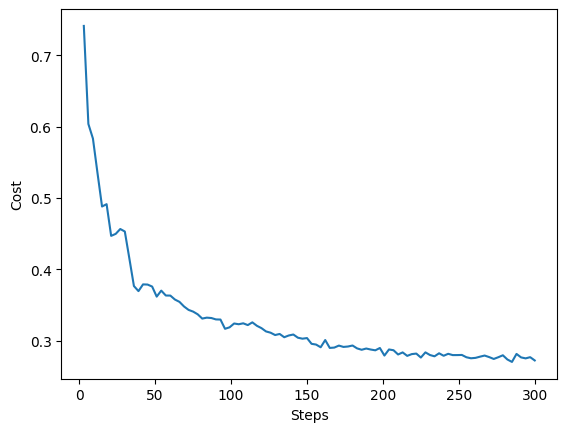

In [29]:
class OptimizerLog:
    """Log to store optimizer's intermediate results"""
    def __init__(self):
        self.evaluations = []
        self.parameters = []
        self.costs = []
    def update(self, evaluation, parameter, cost, _stepsize, _accept):
        """Save intermediate results. Optimizer passes five values
        but we ignore the last two."""
        self.evaluations.append(evaluation)
        self.parameters.append(parameter)
        self.costs.append(cost)

# Set up the optimization
from qiskit.algorithms.optimizers import SPSA
log = OptimizerLog()
optimizer = SPSA(maxiter=100, callback=log.update)

#initial_point = np.random.random(VAR_FORM.num_parameters)
initial_point = np.array([3.28559355, 5.48514978, 5.13099949,
                          0.88372228, 4.08885928, 2.45568528,
                          4.92364593, 5.59032015, 3.66837805,
                          4.84632313, 3.60713748, 2.43546])

def objective_function(variational):
    """Cost function of circuit parameters on training data.
    The optimizer will attempt to minimize this."""
    return cost_function(TRAIN_DATA, TRAIN_LABELS, variational)

# Run the optimization
result = optimizer.minimize(objective_function, initial_point)

opt_var = result.x
opt_value = result.fun

import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(log.evaluations, log.costs)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.show()

Now lets see how our model performs on some test data by measuring the accuracy in the predictions where we decide the prediction based on the class that has the higher probability.

In [30]:
def test_classifier(data, labels, variational):
    """Gets classifier's most likely predictions and accuracy of those
    predictions.

    Args:
        data (list): List of data points to classify
        labels (list): List of correct labels for each data point
        variational (list): List of parameter values for classifier

    Returns:
        float: Average accuracy of classifier over `data`
        list: Classifier's label predictions for each data point
    """
    probability = classification_probability(data, variational)
    predictions = [0 if p[0] >= p[1] else 1 for p in probability]
    accuracy = 0
    for i, prediction in enumerate(predictions):
        if prediction == labels[i]:
            accuracy += 1
    accuracy /= len(labels)
    return accuracy, predictions

accuracy, predictions = test_classifier(TEST_DATA, TEST_LABELS, opt_var)
accuracy

0.9

90% is not too bad. We can plot all the data points below (training and test) and mark which one was classified incorrectly by our quantum circuit model.

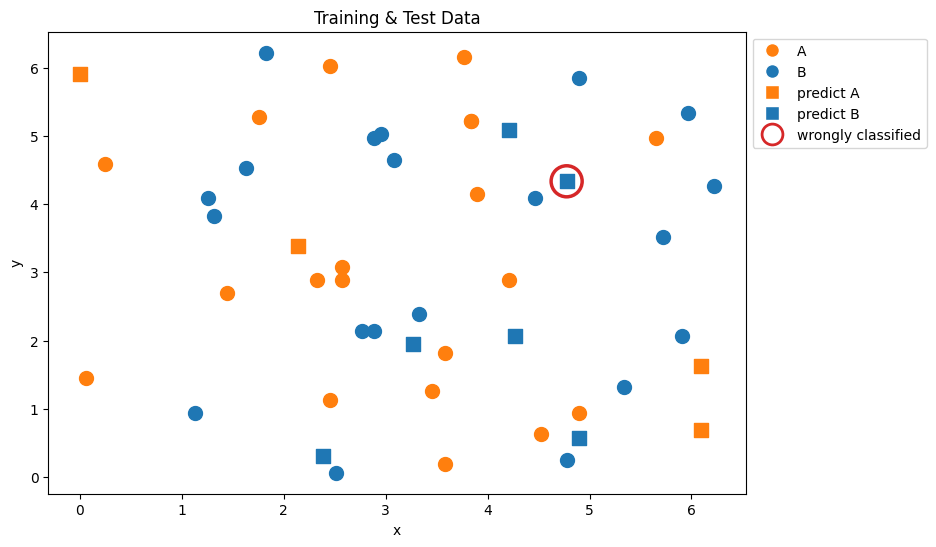

In [31]:
from matplotlib.lines import Line2D
plt.figure(figsize=(9, 6))

for feature, label in zip(TRAIN_DATA, TRAIN_LABELS):
    COLOR = 'C0' if label == 0 else 'C1'
    plt.scatter(feature[0], feature[1],
                marker='o', s=100, color=COLOR)

for feature, label, pred in zip(TEST_DATA, TEST_LABELS, predictions):
    COLOR = 'C0' if pred == 0 else 'C1'
    plt.scatter(feature[0], feature[1],
                marker='s', s=100, color=COLOR)
    if label != pred:  # mark wrongly classified
        plt.scatter(feature[0], feature[1], marker='o', s=500,
                    linewidths=2.5, facecolor='none', edgecolor='C3')

legend_elements = [
    Line2D([0], [0], marker='o', c='w', mfc='C1', label='A', ms=10),
    Line2D([0], [0], marker='o', c='w', mfc='C0', label='B', ms=10),
    Line2D([0], [0], marker='s', c='w', mfc='C1', label='predict A',
           ms=10),
    Line2D([0], [0], marker='s', c='w', mfc='C0', label='predict B',
           ms=10),
    Line2D([0], [0], marker='o', c='w', mfc='none', mec='C3',
           label='wrongly classified', mew=2, ms=15)
]

plt.legend(handles=legend_elements, bbox_to_anchor=(1, 1),
           loc='upper left')

plt.title('Training & Test Data')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Its possible that with more training or better initial conditions, it could have achieved 100% accuracy.

### Qiskit implementation

We can repeat the above but instead use some of the out-of-the-box implementations available in Qiskit. First, the VQC class requires that the labels be one-hot-encoded (instead of their current form).

In [32]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
train_labels_oh = encoder.fit_transform(TRAIN_LABELS.reshape(-1, 1)
                                       ).toarray()
test_labels_oh = encoder.fit_transform(TEST_LABELS.reshape(-1, 1)
                                      ).toarray()

Next, we can set an initial point for our parameter values, our log, and the VQC which uses the same feature map, ansatz, loss function, and optimizer. Then we'll fit the data.

<b>Note:</b> The initial parameter values below are different from the manual implementation. I have no idea where Qiskit got these separate sets of parameters, but I assume random initiation but they hard-coded them so results could be repeatable. In any case, that might have impacted the results differing from this model and the earlier one as they could have found different minima in the loss landscape.

In [33]:
#initial_point = np.random.random(VAR_FORM.num_parameters)
initial_point = np.array([0.3200227 , 0.6503638 , 0.55995053,
                          0.96566328, 0.38243769, 0.90403094,
                          0.82271449, 0.26810137, 0.61076489,
                          0.82301609, 0.11789148, 0.29667125])

from qiskit_machine_learning.algorithms.classifiers import VQC
log = OptimizerLog()
vqc = VQC(feature_map=FEATURE_MAP,
          ansatz=VAR_FORM,
          loss='cross_entropy',
          optimizer=SPSA(callback=log.update),
          initial_point=initial_point,
          quantum_instance=BasicAer.get_backend('qasm_simulator'))

vqc.fit(TRAIN_DATA, train_labels_oh)

/var/folders/f6/glc4hjkn44gg3qtb6mq_88kc0000gq/T/ipykernel_44081/2378846656.py:9: DeprecationWarning: The quantum_instance argument is deprecated as of version 0.5.0 and will be removed no sooner than 3 months after the release. Instead use the sampler argument.
  vqc = VQC(feature_map=FEATURE_MAP,


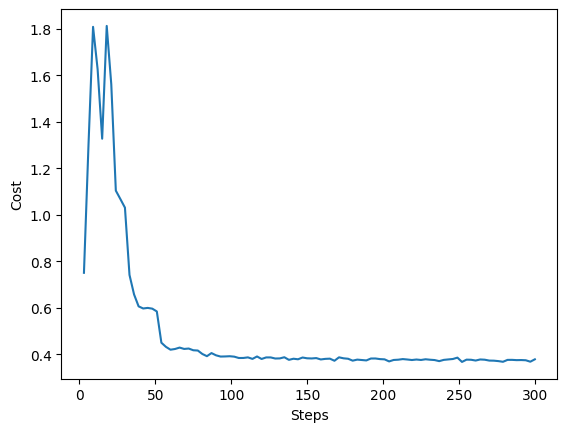

In [34]:
fig = plt.figure()
plt.plot(log.evaluations, log.costs)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.show()

In [35]:
# score == accuracy
vqc.score(TEST_DATA, test_labels_oh)

1.0

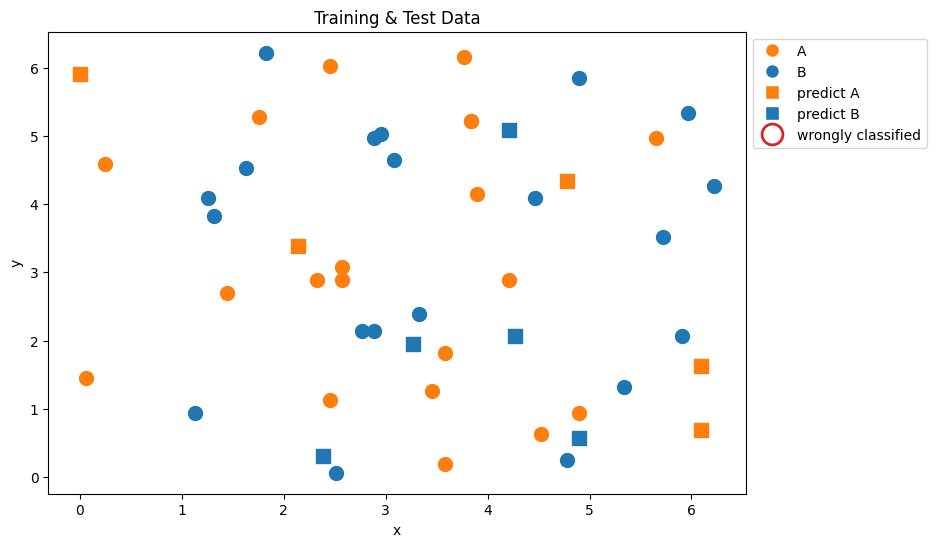

In [36]:
from matplotlib.lines import Line2D
plt.figure(figsize=(9, 6))

for feature, label in zip(TRAIN_DATA, train_labels_oh):
    COLOR = 'C1' if label[0] == 0 else 'C0'
    plt.scatter(feature[0], feature[1], marker='o', s=100,
                color=COLOR)

for feature, label, pred in zip(TEST_DATA, test_labels_oh,
                                vqc.predict(TEST_DATA)):
    COLOR = 'C1' if pred[0] == 0 else 'C0'
    plt.scatter(feature[0], feature[1], marker='s', s=100, color=COLOR)
    if not np.array_equal(label,pred):  # mark wrongly classified
        plt.scatter(feature[0], feature[1], marker='o', s=500,
                    linewidths=2.5, facecolor='none', edgecolor='C3')

legend_elements = [
    Line2D([0], [0], marker='o', c='w', mfc='C1', label='A', ms=10),
    Line2D([0], [0], marker='o', c='w', mfc='C0', label='B', ms=10),
    Line2D([0], [0], marker='s', c='w', mfc='C1', label='predict A',
           ms=10),
    Line2D([0], [0], marker='s', c='w', mfc='C0', label='predict B',
           ms=10),
    Line2D([0], [0], marker='o', c='w', mfc='none', mec='C3',
           label='wrongly classified', mew=2, ms=15)
]

plt.legend(handles=legend_elements, bbox_to_anchor=(1, 1),
           loc='upper left')

plt.title('Training & Test Data')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

We can compare the different parameter values found by the two models that were implemented manually vs qiskit that started with different initial points. Since these are the values for the rotation gates, these should be radians so lets convert them to degress just so we can compare them a bit easier.

In [45]:
vqc._fit_result._x

array([ 0.33481656,  3.93645761, -3.66392308,  0.30750656,  3.60294897,
       -4.42566729,  2.37744092,  1.9864547 ,  2.45047016,  0.63681805,
        3.46055764,  1.12785062])

In [46]:
opt_var

array([2.38852489, 5.36132596, 5.61907989, 0.38547017, 2.7347967 ,
       2.31715277, 4.30483242, 5.15210369, 4.71274762, 4.65192942,
       2.43950769, 1.94741681])

In [47]:
np.rad2deg(vqc._fit_result._x)

array([  19.18357553,  225.54240712, -209.92732905,   17.61882795,
        206.43376953, -253.57205722,  136.21733073,  113.81547029,
        140.401598  ,   36.48698679,  198.27534772,   64.62108053])

In [48]:
np.rad2deg(opt_var)

array([136.85239552, 307.18135012, 321.94956253,  22.08581371,
       156.69230879, 132.76307432, 246.64872937, 295.19379694,
       270.0205487 , 266.53592215, 139.77349498, 111.57876438])

<font color="red">Question/Comment: </font> The two models performed comparable (90% vs 100% but for only 10 datapoints) but when we look at their parameters, overall they're not very similar. So is there anyway to figure out what the algorithm is "learning" from the data? Such as which features have a bigger impact on the final classification and which do not?

## Variational training

Finding the optimal parameters of the variational circuit takes most of the processing time. The optimal circuit parameters are identified when the minimum of the loss function is found. The loss function has a landscape thhat can be complicated and the optimization method navigates about this landscape to search for a minimum value. As discussed in other sections, sometimes the optimizer finds a local minimum and sometimes it finds a global minimum.

Optimization methods can be either gradient-based or gradient-free. Gradient-based methods can have slow convergence and no guarantee to achieve the optimal solution. Gradient-free methods are useful when derivative information is unavailable or impractical to obtain and tend to find the global minimum better than gradient-based techniques. But these require higher computational capacities.

One general challenge is the barren plateau problem discussed earlier. Efforts to overcome that include structured initial guesses (quantum simulation) as well as training a sequence of shallow blocks.